# Project: Gather and Clean WeRateDogs Data
## Table of Contents
- Introduction
- Data Gathering
- Data Assessing and Cleaning
- Data Analysis

## Introduction

In this project, we collect, assess and clean the data from the WeRateDogs archive. We will use the tweepy API to collect the data from Twitter and then we will create a pandas DataFrame. We will find out the issues with this DataFrame in both tidiness and quality and we will fix issues we find.

## Gather
We have already set up a twitter developer account, let's use tweepy to access the API. Let's use pandas to read the csv file containing the twitter archive and use requests to download the image prediction tsv file.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

response = requests.get(url)
with open('image_predictions.tsv','wb') as file:
    file.write(response.content)

image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')

In [2]:
import tweepy

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [3]:
# Use a for loop to read out contents from each twitter id in the archive
# Then write to tweet_json.txt
import json
import time
print('Total number of id: ', twitter_archive.tweet_id.shape[0])
start_time = time.time()
count = 0
fail = 0
with open('tweet_json.txt', 'w') as file:
    for tweet_id in twitter_archive.tweet_id:
        count += 1
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json.dump(tweet._json, file)
            file.write('\n')
        except:
            fail += 1
            pass
        if count % 200 == 0: print("count:", count)
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))
print("Number of fails: " , fail)

Total number of id:  2356
count: 200
count: 400
count: 600
count: 800
Rate limit reached. Sleeping for: 729
count: 1000
count: 1200
count: 1400
count: 1600
count: 1800
Rate limit reached. Sleeping for: 728
count: 2000
count: 2200
Number of fails:  25


In [4]:
elapsed_time

'00:31:55'

We will read out the contents of each tweet id and append them to a list and them construct a DataFrame object from this list.

In [5]:
tweet_data = []
with open('tweet_json.txt','r') as file:
    line = file.readline()
    while line:
        data = json.loads(line)
        tweet_data.append({'tweet_id':data['id'],
                          'retweet_count': data['retweet_count'],
                          'favorite_count': data['favorite_count']})
        line = file.readline()

In [6]:
df_extra = pd.DataFrame(tweet_data,columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

In [7]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


Lets write this DataFrame to a csv file, so later if we restart terminal we will read from this csv file instead of spending time to gather again.

In [8]:
df_extra.to_csv('tweet_data_extra.csv', index = False)

## Assess Data
In this section we will assess the data that was gathered. Using both visual assessment and programmatic assessment.

The tidiness of the data is assessed with the standards defined by Hadley Wikham:
1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

The quality of the data is assessed by completeness, validity, accuracy, etc.

Let's reload the data, in case we restart the kernel, we can start from here.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')
df_extra = pd.read_csv('tweet_data_extra.csv')

Let's assess and clean these data one by one:
## Archive Data
#### Assess

In [10]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1231,713177543487135744,NaN,NaN,2016-03-25 01:35:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lance. Lance doesn't give a shit. 10/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713177543...,10,10,Lance,None,None,None,None
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None
1784,677662372920729601,NaN,NaN,2015-12-18 01:31:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",In honor of the new Star Wars movie. Here's Yo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677662372...,12,10,None,None,None,None,None
2042,671538301157904385,NaN,NaN,2015-12-01 03:56:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Baxter. He's very calm. Hasn't eaten i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671538301...,8,10,Baxter,None,None,None,None
1702,680934982542561280,NaN,NaN,2015-12-27 02:15:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Sadie. She's a Tortellini Sidewin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680934982...,10,10,Sadie,None,None,None,None


In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### Notes:
There are several problems we can see:
1. There are 181 **retweets** (retweet_status_id etc is not NAN) (quality)
2. Missing data from **expanded_url**, showing 59 missing data. (quality)
3. The **timestamp** column is in string format, and should be datetime.(quality)
4. There are 4 columns of **dog stages**, there should only be one, and should be category type instead of string type. Also, most rows are missing this information. (quality and tidiness)
5. The minimum **rating_denominator** is 0 which is not correct. (quality)
6. The **name** column doesn't have missing values but many of them are 'None'. (quality)

upon detail inspection, many of the entries with wrong names are retweets. So let's take care of these first!

## clean

**Remove retweets**

In [14]:
archive_clean = twitter_archive.query("retweeted_status_id == 'Nan'")
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

Now that we removed the retweet rows lets also drop all the retweet related column because we wont need those anymore.

In [15]:
archive_clean = archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id',
                    'retweeted_status_timestamp'],axis = 1)

In [16]:
archive_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


**expanded_urls**

Let's look into the issue of missing expanded_urls. Now we only need the data with dog pictures. To double check lets see if any of these tweets are in the image prediction data.

In [17]:
pd.merge(archive_clean[archive_clean.expanded_urls.isnull()],image_prediction, 
         how = 'inner', on = 'tweet_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


So none of these entries are in the image prediction data. We can simply drop them. Or better since we will merge table later, they will be dropped automatically.

**Timestamp**

We will change timestamp type from string to datetime.

In [18]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [19]:
archive_clean.timestamp.describe()

count                    2175
unique                   2175
top       2016-09-12 15:10:21
freq                        1
first     2015-11-15 22:32:08
last      2017-08-01 16:23:56
Name: timestamp, dtype: object

**dog stages**

Let's merge the dog stages column into one single column and drop these original columns. By observation, each column is a string type with the word being either 'None' or the name of that dog stage.

In [20]:
doggo = archive_clean['doggo'].apply(lambda x: x if x!='None' else '') 
floofer = archive_clean['floofer'].apply(lambda x: x if x!='None' else '')
pupper = archive_clean['pupper'].apply(lambda x: x if x!='None' else '')
puppo = archive_clean['puppo'].apply(lambda x: x if x!='None' else '') 

In [21]:
archive_clean['dog_stages'] = doggo + floofer + pupper + puppo

In [22]:
archive_clean['dog_stages'].value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

It seems that some of the rows have two values.

In [23]:
pd.set_option('display.max_colwidth', -1)
archive_clean.query('dog_stages == "doggopupper"').expanded_urls

460     https://twitter.com/dog_rates/status/817777686764523521/video/1                                                                
531     https://twitter.com/dog_rates/status/808106460588765185/photo/1                                                                
565     https://twitter.com/dog_rates/status/802265048156610565/photo/1                                                                
575     https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1
705     https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1
733     https://vine.co/v/5rgu2Law2ut                                                                                                  
889     https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1
956     https://twitter.com/dog_rates/status/751

Upon inspection, most of these entries have two photos of different dog stages, or a photo with two dogs with different stages. Because the number is so small I will set them all to 'doggo', I don't think it affects the result much.

In [24]:
import numpy as np
archive_clean.dog_stages = archive_clean.dog_stages.str.replace('doggopupper','doggo')\
.str.replace('doggopuppo', 'doggo').str.replace('doggofloofer', 'doggo')
archive_clean.loc[archive_clean.dog_stages == '','dog_stages'] = np.nan
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dog_stages               344 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(9)
memory usage: 271.9+ KB


Drop the original columns.

In [25]:
archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1,
                   inplace = True)
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
dog_stages               344 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 203.9+ KB


Change type to category.

In [26]:
archive_clean.dog_stages = archive_clean.dog_stages.astype('category')
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
dog_stages               344 non-null category
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 189.2+ KB


**rating denominator**

The minimum denominator is 0, lets find out this or these data. We found that most data has denominator 10. I would also argue that most people use 10 points as full, anything else is worth looking at.

In [27]:
archive_clean.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,960,0,None,NaN
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,11,15,None,NaN
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,NaN
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,NaN
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,NaN
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,NaN
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,NaN


Entries doesn't have extended url so it will be removed later, entry that does have url after checking, in most cases there are multiple dogs, or the date may have been misinterpreted as score. We could take average for multiple dogs and fix the errors manually, but I find it too time consuming and this is just a small portion of the data, so we'll drop these. 

In [28]:
archive_clean = archive_clean.query('rating_denominator == 10')
archive_clean.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator
count,2.153000e+03,7.300000e+01,7.300000e+01,2153.000000,2153.0
mean,7.372472e+17,7.456060e+17,2.152128e+16,12.250813,10.0
std,6.761351e+16,7.600519e+16,1.294404e+17,42.679419,0.0
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,10.0
25%,6.767764e+17,6.754971e+17,3.589728e+08,10.000000,10.0
50%,7.098528e+17,7.044857e+17,4.196984e+09,11.000000,10.0
75%,7.895992e+17,8.233264e+17,4.196984e+09,12.000000,10.0
max,8.924206e+17,8.862664e+17,8.405479e+17,1776.000000,10.0


The minimum numerator is still 0.

In [29]:
archive_clean.query('rating_numerator < 4')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,NaN
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1",3,10,Wesley,NaN
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,NaN
1189,718246886998687744,NaN,NaN,2016-04-08 01:19:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl,https://twitter.com/dog_rates/status/718246886998687744/photo/1,3,10,Alexanderson,NaN
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz,"https://twitter.com/dog_rates/status/711306686208872448/photo/1,https://twitter.com/dog_rates/status/711306686208872448/photo/1",3,10,None,NaN
1314,706901761596989440,NaN,NaN,2016-03-07 17:58:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10 https://t.co/FMUxir5pYu,https://twitter.com/dog_rates/status/706901761596989440/photo/1,3,10,Elliot,NaN
1406,699088579889332224,NaN,NaN,2016-02-15 04:31:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/VfLoDZecJ7,https://twitter.com/dog_rates/status/699088579889332224/photo/1,3,10,Charl,NaN
1446,696490539101908992,6.964887e+17,4.196984e+09,2016-02-08 00:27:39,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me,NaN,1,10,None,NaN
1478,693590843962331137,NaN,NaN,2016-01-31 00:25:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Phil. He's big af. Currently destroying this nice family home. Completely uncalled for. 3/10 not a good pupper https://t.co/fShNNhBWYx,https://twitter.com/dog_rates/status/693590843962331137/photo/1,3,10,Phil,pupper
1601,686003207160610816,NaN,NaN,2016-01-10 01:54:44,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 must be rare https://t.co/NOIiRWr5Jf,https://twitter.com/dog_rates/status/686003207160610816/photo/1,3,10,Hammond,NaN


I just went through some of these very low rating postings and most of them are not even dogs. There are lizards, pigs, lambs, bugs etc. Some of them are trying to be funny, and some other are giving 0 rating because of plagerism or that he "cannot find a dog to pet". I suppose the image prediction should take care of these and identify these as non-dogs. We'll leave them be for now.

In [30]:
archive_clean.query('rating_numerator > 15')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,17,10,None,NaN
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,420,10,None,NaN
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,666,10,None,NaN
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,182,10,None,NaN
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,pupper
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,NaN
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,NaN
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,None,NaN


Manually fix the three entries that are misread and drop the rest.

In [31]:
archive_clean.loc[[695,763,1712],'rating_numerator'] = [[10],[11],[11]]
archive_clean.loc[[695,763,1712]]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,10,10,Logan,NaN
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11,10,Sophie,pupper
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11,10,None,NaN


In [32]:
archive_clean = archive_clean.query('rating_numerator <= 15')
archive_clean.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator
count,2.147000e+03,6.900000e+01,6.900000e+01,2147.000000,2147.0
mean,7.370474e+17,7.390981e+17,2.276889e+16,10.619003,10.0
std,6.748798e+16,7.292570e+16,1.330848e+17,2.194030,0.0
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,10.0
25%,6.766970e+17,6.753494e+17,1.582854e+09,10.000000,10.0
50%,7.095570e+17,7.030419e+17,4.196984e+09,11.000000,10.0
75%,7.892914e+17,8.116272e+17,4.196984e+09,12.000000,10.0
max,8.924206e+17,8.862664e+17,8.405479e+17,15.000000,10.0


**name**

Let's change the 'None' values to null entries.

In [33]:
archive_clean.loc[archive_clean.name == "None", 'name'] = np.nan
archive_clean.name.value_counts().head(5)

a          54
Charlie    11
Lucy       11
Oliver     10
Cooper     10
Name: name, dtype: int64

I noticed there are other issues with names, for example 'a', 'the' are clearly not valid names, but I imagine this isn't so important in analysis, so let's leave them be for now.

## Image Prediction Data

We've finished cleaning the issues with the tweeter archive data, let's assess and clean the prediction data.

### Assess

Issue we found with this dataset:
- There are three different predictions for each row, but we only need one prediction to present. (tidiness)

In [34]:
image_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1872,844979544864018432,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,3,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True
1865,843235543001513987,https://pbs.twimg.com/media/C7PGQJAWwAAibui.jpg,1,Pembroke,0.958452,True,Cardigan,0.023770,True,Chihuahua,0.005269,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
1222,744334592493166593,https://pbs.twimg.com/media/ClRoXGwWIAEVVzc.jpg,1,Samoyed,0.960543,True,Pomeranian,0.012192,True,white_wolf,0.004753,False
416,674019345211760640,https://pbs.twimg.com/media/CVqZBO8WUAAd931.jpg,1,collie,0.992732,True,borzoi,0.005043,True,Shetland_sheepdog,0.001725,True


In [35]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [36]:
image_prediction.query("p1_dog == False & p2_dog == False & p3_dog == False").sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1481,780931614150983680,https://pbs.twimg.com/media/CtZtJxAXEAAyPGd.jpg,1,padlock,0.731564,False,necklace,0.065462,False,chain,0.036469,False
1242,747204161125646336,https://pbs.twimg.com/media/Cl6aOBhWEAALuti.jpg,2,coil,0.533699,False,dugong,0.087959,False,rain_barrel,0.039221,False
660,682406705142087680,https://pbs.twimg.com/media/CXhlRmRUMAIYoFO.jpg,1,wombat,0.709344,False,koala,0.169758,False,beaver,0.079433,False


I checked the accuracies of the predictions, it seems that if p1 prediction is not dog, if p2 prediction is dog, p2 prediction is still quite accurate. But if p2 still predicts not dog, and p3 prediction is dog, the prediction is quite bad.

In [37]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Clean

For this analysis, it doesn't help having 9 columns for a dog type prediction. We will do this to the prediction columns: If p1 is dog, prediction equals p1. If p1 is not dog, and p2 is dog, prediction equals p2. If both p1 and p2 are not dog, drop this row no matter what p3 is.

In [38]:
prediction_clean = image_prediction.copy()
prediction_clean['prediction'] = prediction_clean.p1_dog * prediction_clean.p1 +\
((~prediction_clean.p1_dog)&prediction_clean.p2_dog) * prediction_clean.p2
prediction_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction
149,668636665813057536,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg,1,komondor,0.999956,True,llama,0.000043,False,ram,2.160900e-07,False,komondor
759,688804835492233216,https://pbs.twimg.com/media/CY8gWFRWUAAm1XL.jpg,3,malinois,0.199512,True,German_shepherd,0.096797,True,Saluki,8.284820e-02,True,malinois
496,675781562965868544,https://pbs.twimg.com/media/CWDbv2yU4AARfeH.jpg,1,Maltese_dog,0.921968,True,West_Highland_white_terrier,0.017811,True,toy_poodle,1.355540e-02,True,Maltese_dog
478,675334060156301312,https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg,2,Pembroke,0.773135,True,Cardigan,0.116810,True,chow,3.903620e-02,True,Pembroke
831,693642232151285760,https://pbs.twimg.com/media/CaBP7i9W0AAJrIs.jpg,1,Scottish_deerhound,0.111893,True,bluetick,0.074302,True,German_short-haired_pointer,6.700040e-02,True,Scottish_deerhound


Drop the p1-p3 rows.

In [39]:
prediction_clean.drop(['p1','p1_dog','p1_conf',
                       'p2','p2_dog','p2_conf',
                       'p3','p3_dog','p3_conf'],
                      axis = 1, inplace = True)
prediction_clean.sample(5)

,tweet_id,jpg_url,img_num,prediction
646,681654059175129088,https://pbs.twimg.com/media/CXW4wGHWsAE_eBD.jpg,1,Pomeranian
1966,867774946302451713,https://pbs.twimg.com/media/DAr0tDZXUAEMvdu.jpg,2,Border_collie
856,696754882863349760,https://pbs.twimg.com/media/Cate3eLUcAEIuph.jpg,1,toy_poodle
1411,770772759874076672,https://pbs.twimg.com/media/CrJVupHXgAA4Dkk.jpg,1,chow
1032,711652651650457602,https://pbs.twimg.com/media/CeBMT6-WIAA7Qqf.jpg,1,


In [40]:
prediction_clean.loc[prediction_clean.prediction == '','prediction'] = np.nan
prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
img_num       2075 non-null int64
prediction    1687 non-null object
dtypes: int64(2), object(2)
memory usage: 64.9+ KB


It seems quite an amount of data is predicted as not dog, but not all of them are not dogs. So instead of dropping them, we will keep them for now.

In [41]:
prediction_clean.prediction.unique().shape[0]

113

## Extra Information from Twitter API

There wasn't too much issue with prediction data. Let's look at the extra information we gathered from twitter API now.

### Assess

In [42]:
df_extra.sample(5)

,tweet_id,retweet_count,favorite_count
912,753375668877008896,2351,7742
116,869596645499047938,2926,15257
1425,696100768806522880,656,1945
1141,722974582966214656,1561,4108
503,810254108431155201,3466,15092


In [43]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [44]:
df_extra.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2723.438438,7617.624196
std,6.823170e+16,4606.545511,11819.007839
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,549.500000,1331.000000
50%,7.182469e+17,1279.000000,3316.000000
75%,7.986692e+17,3162.000000,9342.000000
max,8.924206e+17,78412.000000,157536.000000


In [45]:
df_extra.duplicated().sum()

0

I didn't see any issue with this data set.

## Merging Datasets - Tidiness issue

- All these information belongs to the same table, so we should merge them into a single table. (tidiness)

First let's merge **archive_clean** and **prediction_clean**, so we are not interested in any entry with just rating and no image, or only image and no ratings, we should use inner join.

In [46]:
archive_clean_merged = pd.merge(archive_clean, prediction_clean, how = 'inner',
                               on = 'tweet_id')
archive_clean_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 1973
Data columns (total 14 columns):
tweet_id                 1974 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1974 non-null datetime64[ns]
source                   1974 non-null object
text                     1974 non-null object
expanded_urls            1974 non-null object
rating_numerator         1974 non-null int64
rating_denominator       1974 non-null int64
name                     1441 non-null object
dog_stages               306 non-null category
jpg_url                  1974 non-null object
img_num                  1974 non-null int64
prediction               1608 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 218.0+ KB


Now let's also join in the extra information from twitter API. Now it is quite OK to have a data with everything else except retweet and favorite count, but data with only retweet and favorite count doesn't mean much. So left join.

In [47]:
archive_clean_merged = pd.merge(archive_clean_merged, df_extra, how = 'left',
                               on = 'tweet_id')
archive_clean_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 1973
Data columns (total 16 columns):
tweet_id                 1974 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1974 non-null datetime64[ns]
source                   1974 non-null object
text                     1974 non-null object
expanded_urls            1974 non-null object
rating_numerator         1974 non-null int64
rating_denominator       1974 non-null int64
name                     1441 non-null object
dog_stages               306 non-null category
jpg_url                  1974 non-null object
img_num                  1974 non-null int64
prediction               1608 non-null object
retweet_count            1967 non-null float64
favorite_count           1967 non-null float64
dtypes: category(1), datetime64[ns](1), float64(4), int64(4), object(6)
memory usage: 248.9+ KB


In [48]:
archive_clean_merged.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,jpg_url,img_num,prediction,retweet_count,favorite_count
1603,672995267319328768,NaN,NaN,2015-12-05 04:25:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pumpkin. He can look in two different directions at once. Great with a screwdriver. 8/10 https://t.co/odpuqtz2Fq,https://twitter.com/dog_rates/status/672995267319328768/photo/1,8,10,Pumpkin,NaN,https://pbs.twimg.com/media/CVb1mRiWcAADBsE.jpg,1,French_bulldog,278.0,923.0
1333,681654059175129088,NaN,NaN,2015-12-29 01:52:46,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Toffee. He's a happy pupper. Appears dangerously fluffy. Extraordinarily spherical. 12/10 would pet firmly https://t.co/oEXEKt3MHu,https://twitter.com/dog_rates/status/681654059175129088/photo/1,12,10,Toffee,pupper,https://pbs.twimg.com/media/CXW4wGHWsAE_eBD.jpg,1,Pomeranian,923.0,2650.0
1870,667866724293877760,NaN,NaN,2015-11-21 00:46:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https://t.co/SBmWbfAg6X,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,NaN,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,NaN,987.0,2923.0


# Visualize

Now we have finished all cleaning, and merged all datasets into one table. Let's do some visualization.

**Q1. What is the most common tweeted dogs?**

In [49]:
# For convenience we will use a shorter name archive for archive_clean_merged
archive = archive_clean_merged

In [50]:
top10 = archive.prediction.value_counts().head(10)

In [51]:
top10 = top10.sort_values(ascending = False)
top10

golden_retriever      148
Labrador_retriever    102
Pembroke              93 
Chihuahua             89 
pug                   58 
toy_poodle            47 
chow                  44 
Samoyed               41 
Pomeranian            41 
malamute              31 
Name: prediction, dtype: int64

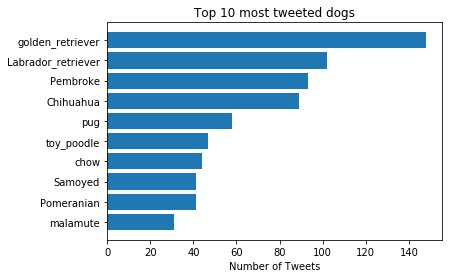

In [52]:
import matplotlib.pyplot as plt
plt.barh(range(9,-1,-1), top10, tick_label = top10.index)
plt.xlabel('Number of Tweets')
plt.title('Top 10 most tweeted dogs')
plt.show()

So the most tweeted dog type is golden retriever and the top ten most tweeted dog types are shown above.

**Q2. Which type of dog have the highest average rating?**

We take the average of the rating_numerators, however we found out that some of the dog types only have 1 or a few ratings making it very biases. So lets only consider dog types with over ten ratings.

In [53]:
archive_mean = archive.groupby(['prediction']).mean().reset_index()

In [54]:
rating_rank =  archive_mean[['prediction','rating_numerator']].copy()
rating_rank.loc[:,'tweet_num'] =  archive.groupby(['prediction']).count().reset_index().tweet_id
rating10 = rating_rank.query('tweet_num >= 10').sort_values(['rating_numerator']).tail(10)
rating10

,prediction,rating_numerator,tweet_num
6,Bernese_mountain_dog,11.272727,11
82,cocker_spaniel,11.285714,28
91,kelpie,11.307692,13
59,Siberian_husky,11.315789,19
48,Pembroke,11.387097,93
27,Great_Pyrenees,11.428571,14
80,chow,11.522727,44
88,golden_retriever,11.581081,148
21,Eskimo_dog,11.600000,20
54,Samoyed,11.731707,41


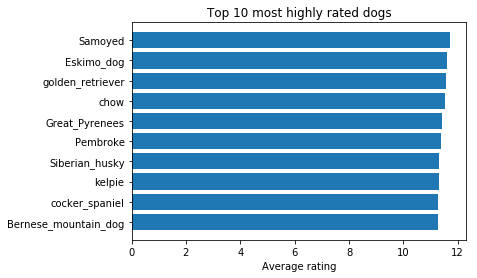

In [55]:
import matplotlib.pyplot as plt
plt.barh(range(10), rating10.rating_numerator, tick_label = rating10.prediction)
plt.xlabel('Average rating')
plt.title('Top 10 most highly rated dogs')
plt.show()

**Q3. Is rating, retweet and favorite count correlated?**

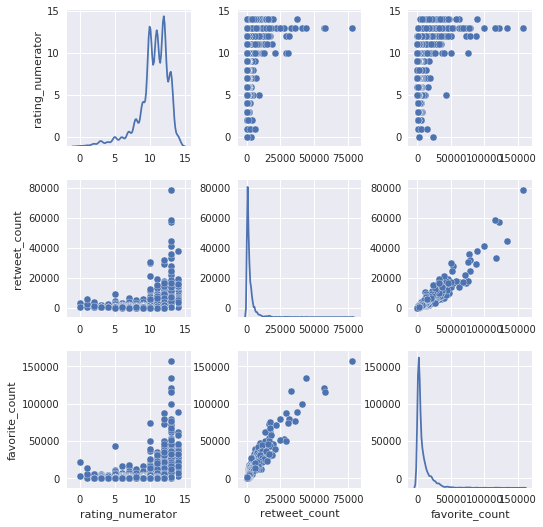

In [56]:
sns.set(style = 'darkgrid')
archive_temp = archive[['rating_numerator', 'retweet_count','favorite_count']].dropna()
sns.pairplot(archive_temp, vars = ['rating_numerator', 'retweet_count','favorite_count'],
            diag_kind = 'kde')

We can see that retweet and favorite count are highly positively correlated. Rating and favorite count are also correlated, specifically only tweets with high ratings get high retweet or favorite, which is expected.

**Q4. How does the tweet numbers, retweet and favorite counts change with time?**

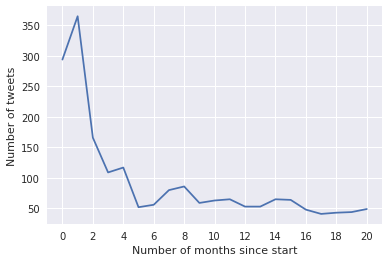

In [57]:
archive['month'] = archive.timestamp.apply(
    lambda x:((x.year-2015)*12 + (x.month-11)))
tweet_vs_month = archive.groupby('month').count()
plt.plot(tweet_vs_month.tweet_id[0:-1])
# The data of the last month is incomplete, let's not count that
plt.xlabel('Number of months since start')
plt.ylabel('Number of tweets')
plt.xticks(range(0,22,2));

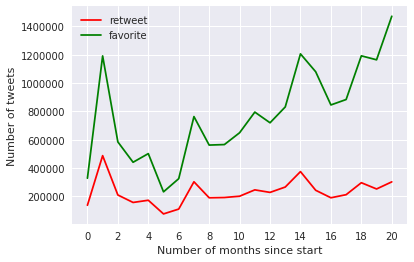

In [58]:
retweet_vs_month = archive.groupby('month').sum()
plt.plot(retweet_vs_month.index[0:-1], retweet_vs_month.retweet_count[0:-1],
         'r',label = 'retweet')
plt.plot(retweet_vs_month.index[0:-1], retweet_vs_month.favorite_count[0:-1],
         'g',label = 'favorite')
# The data of the last month is incomplete, let's not count that
plt.xlabel('Number of months since start')
plt.ylabel('Number of tweets')
plt.legend()
plt.xticks(range(0,22,2));

We can see that the number of tweets seem to drop after the initial 5 months and then stable at about 50/month. This is expected since the initial high popularity probably caused a surge in tweet numbers and after the popularity cools down it stablized.
For retweets and favorites, they seem to see a steady increase over time. Which probably means people are still interested in browsing this page.

# Conclusion

We gathered the necessary data from csv file, an online file and also using the twitter API.
We assessed the three datasets in terms of tidiness and quality. We made the necessary cleaning, and merged the three datasets into one.
We analyzed and visualized the most tweeted and the most highly rated dog types. We determined the positive correlation between rating, retweet numbers and favorite counts. We also visualized the trend of tweet numbers, retweet numbers and favorite counts for the WeRateDogs twitter page.